# b-tagging optimization studies

**Goal:** Max asked me to do the SM HH studies for the b-tagging optimization talk.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import itertools

import uproot
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray

import os
os.sys.path.append('../code')
from AnalysisUtils import nanoToDf, getExpectedBand, getBkgSysBand, getLambdaWeights, hackHistogram
from plotting import sig_bkg_massplanes
from analysis import read_tsv

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


## Step 1: Import data

Since I have several dataframes, maybe I should consider making a dictionary that loads these in?

In [2]:
fDir = "../../hh4b/hh4b-resolved-reconstruction" 

**Load in the signal dfs**

In [3]:
lumi15 = 3.2195
lumi16 = 24.5556
lumi = lumi15+lumi16
lumi

27.7751

In [4]:
mdr = {}
bdt = {}

qCols = ['quantile_h1_j1','quantile_h1_j2','quantile_h2_j1','quantile_h2_j2']

for tagger in ['mv2c10','dl1r']:
    for wp in [60,70,77,85]:
        
        key = f"{tagger}_{wp}"
        
        mdr[key] = nanoToDf(f"{fDir}/mdr_{key}.root",ttree="sig")
        bdt[key] = nanoToDf(f"{fDir}/bdt_{key}.root",ttree="sig")
        
        # Add info about the number of selected jets / quantile for each event
        for qi in range(1,6):
            
            c = f'nQ{qi}'
            mdr[key][c] = np.sum(mdr[key][qCols]==qi,axis=1)
            bdt[key][c] = np.sum(bdt[key][qCols]==qi,axis=1)
        
        # Just like they asked me to do last time, take out the event w/ the large negative weight
        mdr[key] = mdr[key][mdr[key]['mc_sf']>-0.002]
        bdt[key] = bdt[key][bdt[key]['mc_sf']>-0.002]
        
        
        # Doing the luminosity normalization here as well
        mdr[key]['mc_sf'] *= lumi
        bdt[key]['mc_sf'] *= lumi
        

sig
sig
sig
sig
sig
sig
sig
sig
sig
sig
sig
sig
sig
sig
sig
sig


**Load in the data**

In [5]:
bkg = nanoToDf(f"{fDir}/data16_bdt_mv2c10_70.root",ttree="fullmassplane")

fullmassplane


In [6]:
bkg.head()

run_number  event_number  mc_sf  ntag  njets  kinematic_region  \
entry                                                                   
0          301932    2484061185    1.0     2      4                 3   
1          301932    2483482446    1.0     3      4                 2   
2          301932    2483306012    1.0     2      4                 1   
3          301932    2484981562    1.0     2      5                 3   
4          301932    2483455297    1.0     2      4                 3   

         m_min_dj    m_max_dj  pairing_score_1  pairing_score_2  ...  \
entry                                                            ...   
0       76.628250  311.813477         0.992624         0.049170  ...   
1       58.775814  183.142578         0.355451         0.248479  ...   
2      122.562546  225.240295         0.742466         0.087963  ...   
3       69.453339  241.872742         0.172362         0.017797  ...   
4      157.857452  443.316895         0.999292         0.000544  ...   

       eta_h2_j2  phi_h2_j2  tag_h2_j2  quantile_h2_j2  angle_h2_j2  \
entry                                                                 
0       0.570596   2.922091      False               1     1.948944   
1       0.911780   0.250331      False               1     1.807956   
2       1.308814  -1.609820      False               1     0.750401   
3      -1.277988   2.467026      False               1     1.410944   
4      -0.606818   2.844027      False               1     1.609269   

             pT_4        pT_2     eta_i    dRjj_1    dRjj_2  
entry                                                        
0       55.882603  144.257782  0.238801  0.754046  1.028020  
1       57.264702   76.716042  0.699040  0.696881  0.969259  
2       41.274769   84.154282  1.161271  1.766645  2.042622  
3       77.585609   89.832199  1.068964  0.753235  2.066677  
4      157.408188  193.768631  0.547820  0.868189  1.514746  

[5 rows x 60 columns]

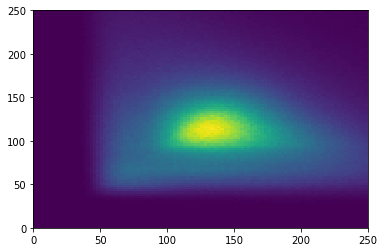

In [7]:
plt.hist2d(bkg.loc[bkg.ntag==2,'m_h1'],bkg.loc[bkg.ntag==2,'m_h2'],100,[[0,250],[0,250]])
plt.show()

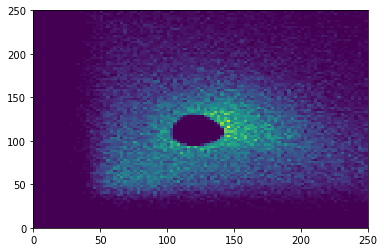

In [8]:
plt.hist2d(bkg.loc[bkg.ntag==4,'m_h1'],bkg.loc[bkg.ntag==4,'m_h2'],100,[[0,250],[0,250]])
plt.show()

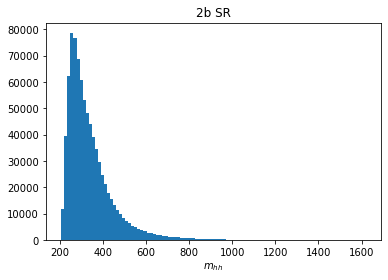

In [9]:
plt.hist(bkg.loc[(bkg.ntag==2)&(bkg.kinematic_region==0),'m_hh'],100)
plt.title('2b SR')
plt.xlabel('$m_{hh}$')
plt.show()

**Load in the four tag cutflows**

In [5]:
col_4tag = ['Initial','Selected','Ntuple','Trigger','4 good jets $\geq$ 2 tagged',
            '4 tagged', '$\Delta R_{jj}$', '$p_T(h)s$','$\Delta \eta_{hh}$',
            'Muon LepTop','Electron LepTop','HadTop','Multijet Enriched',
            '$X_{wt}$','Signal Region','Validation Region','Control Region']

cutflow_4b = pd.DataFrame(None,col_4tag)

for pairingAlg in ['mdr','bdt']:
    for tagger in ['mv2c10','dl1r']:
        for wp in [60,70,77,85]:

            col = f"{pairingAlg}_{tagger}_{wp}"

            rr = uproot.open(f"{fDir}/{col}.root")
            
            cutflow_4b[col] = rr['FourTagCutflow;1'].values
            

Also - I want to look at the data cutflows, but for this I've only looked at 2b and 4b.

In [11]:
len(col_4tag)

17

In [12]:
rr['FourTagCutflow;1'].values.shape

(17,)

In [13]:
col_2tag = ['Initial','Selected','Ntuple','Trigger','4 good jets $\geq$ 2 tagged',
            '2 tagged', '$\Delta R_{jj}$', '$p_T(h)s$','$\Delta \eta_{hh}$',
            'Muon LepTop','Electron LepTop','HadTop','Multijet Enriched',
            '$X_{wt}$','Signal Region','Validation Region','Control Region']

blind_4tag  = ['Initial','Selected','Ntuple','Trigger','4 good jets $\geq$ 2 tagged',
            '4 tagged', '$\Delta R_{jj}$', '$p_T(h)s$','$\Delta \eta_{hh}$',
            'Muon LepTop','Electron LepTop','HadTop','Multijet Enriched',
            '$X_{wt}$','Validation Region','Control Region']

dat2b = pd.DataFrame(None,col_2tag)
dat4b = pd.DataFrame(None,blind_4tag)

pairingAlg = 'bdt'

for tagger in ['mv2c10','dl1r']:
    for wp in [60,70,77,85]:

        if (tagger=='dl1r') and (wp==60):
            continue
        
        col = f"{tagger}_{wp}"

        rr = uproot.open(f"{fDir}/data16_{pairingAlg}_{col}.root")

        dat2b[col] = rr['TwoTagCutflow;1'].values
        dat4b[col] = rr['FourTagCutflow;1'].values

In [14]:
dat2b[['mv2c10_70','mv2c10_77','dl1r_70','dl1r_77']]

mv2c10_70     mv2c10_77       dl1r_70  \
Initial                      5.123611e+09  5.123611e+09  5.123611e+09   
Selected                     8.596592e+08  8.596592e+08  8.596592e+08   
Ntuple                       1.120045e+08  1.120045e+08  1.120045e+08   
Trigger                      6.499295e+07  6.499295e+07  6.499295e+07   
4 good jets $\geq$ 2 tagged  3.878746e+07  4.108913e+07  4.102715e+07   
2 tagged                     3.528088e+07  3.561099e+07  3.796746e+07   
$\Delta R_{jj}$              3.528088e+07  3.561099e+07  3.796746e+07   
$p_T(h)s$                    1.408813e+07  1.418227e+07  1.513569e+07   
$\Delta \eta_{hh}$           1.110626e+07  1.117956e+07  1.193795e+07   
Muon LepTop                  6.904400e+04  7.169300e+04  6.993000e+04   
Electron LepTop              1.485100e+05  1.576270e+05  1.487210e+05   
HadTop                       4.239440e+05  4.192240e+05  4.552610e+05   
Multijet Enriched            1.068231e+07  1.076033e+07  1.148269e+07   
$X_{wt}$                     9.724599e+06  9.806456e+06  1.045837e+07   
Signal Region                8.326720e+05  8.399540e+05  8.940860e+05   
Validation Region            1.010391e+06  1.018707e+06  1.084817e+06   
Control Region               1.506454e+06  1.518795e+06  1.616993e+06   

                                  dl1r_77  
Initial                      5.123611e+09  
Selected                     8.596592e+08  
Ntuple                       1.120045e+08  
Trigger                      6.499295e+07  
4 good jets $\geq$ 2 tagged  4.141126e+07  
2 tagged                     3.662030e+07  
$\Delta R_{jj}$              3.662030e+07  
$p_T(h)s$                    1.457807e+07  
$\Delta \eta_{hh}$           1.149567e+07  
Muon LepTop                  7.267000e+04  
Electron LepTop              1.587570e+05  
HadTop                       4.319000e+05  
Multijet Enriched            1.106377e+07  
$X_{wt}$                     1.008608e+07  
Signal Region                8.634760e+05  
Validation Region            1.046982e+06  
Control Region               1.560376e+06

In [15]:
dat4b[['mv2c10_70','mv2c10_77','dl1r_70','dl1r_77','dl1r_85']]

mv2c10_70     mv2c10_77       dl1r_70  \
Initial                      5.123611e+09  5.123611e+09  5.123611e+09   
Selected                     8.596592e+08  8.596592e+08  8.596592e+08   
Ntuple                       1.120045e+08  1.120045e+08  1.120045e+08   
Trigger                      6.499295e+07  6.499295e+07  6.499295e+07   
4 good jets $\geq$ 2 tagged  3.878746e+07  4.108913e+07  4.102715e+07   
4 tagged                     2.142590e+05  4.081580e+05  1.861500e+05   
$\Delta R_{jj}$              2.142590e+05  4.081580e+05  1.861500e+05   
$p_T(h)s$                    1.055410e+05  1.965480e+05  9.236800e+04   
$\Delta \eta_{hh}$           8.222200e+04  1.533280e+05  7.169200e+04   
Muon LepTop                  3.790000e+02  7.970000e+02  3.290000e+02   
Electron LepTop              3.750000e+02  8.140000e+02  3.030000e+02   
HadTop                       3.587000e+03  7.311000e+03  2.969000e+03   
Multijet Enriched            7.045900e+04  1.305950e+05  6.164900e+04   
$X_{wt}$                     6.238300e+04  1.148700e+05  5.468800e+04   
Validation Region            7.094000e+03  1.317700e+04  6.188000e+03   
Control Region               1.083000e+04  1.992100e+04  9.491000e+03   

                                  dl1r_77       dl1r_85  
Initial                      5.123611e+09  5.123611e+09  
Selected                     8.596592e+08  8.596592e+08  
Ntuple                       1.120045e+08  1.120045e+08  
Trigger                      6.499295e+07  6.499295e+07  
4 good jets $\geq$ 2 tagged  4.141126e+07  4.191137e+07  
4 tagged                     3.393030e+05  8.055730e+05  
$\Delta R_{jj}$              3.393030e+05  8.055730e+05  
$p_T(h)s$                    1.653370e+05  3.779020e+05  
$\Delta \eta_{hh}$           1.288300e+05  2.953170e+05  
Muon LepTop                  6.170000e+02  1.744000e+03  
Electron LepTop              6.700000e+02  2.566000e+03  
HadTop                       5.889000e+03  1.508100e+04  
Multijet Enriched            1.098380e+05  2.498660e+05  
$X_{wt}$                     9.694000e+04  2.185690e+05  
Validation Region            1.115200e+04  2.540100e+04  
Control Region               1.688200e+04  3.812200e+04

In [68]:
data_SR['mv2c10_70'].mc_sf

entry
31          1.0
35          1.0
52          1.0
57          1.0
61          1.0
           ... 
10656357    1.0
10656369    1.0
10656377    1.0
10656404    1.0
10656417    1.0
Name: mc_sf, Length: 832672, dtype: float64

Probably what's mos useful is to compare algs and taggers for a **fixed** WP.

In [16]:
wp = 60
cols = [f"{pairingAlg}_{tagger}_{wp}" for tagger in ['mv2c10','dl1r'] for pairingAlg in ['mdr','bdt']]
cutflow_4b[cols]

mdr_mv2c10_60  bdt_mv2c10_60   mdr_dl1r_60  \
Initial                       26458.627423   26458.627423  26458.627423   
Selected                      26458.627423   26458.627423  26458.627423   
Ntuple                            7.081629       7.081629      7.080420   
Trigger                           4.275045       4.275045      4.272430   
4 good jets $\geq$ 2 tagged       2.858223       2.858223      2.894593   
4 tagged                          0.237985       0.237985      0.241390   
$\Delta R_{jj}$                   0.215243       0.237985      0.219984   
$p_T(h)s$                         0.203290       0.209547      0.207686   
$\Delta \eta_{hh}$                0.183561       0.188859      0.187048   
Muon LepTop                       0.000000       0.000000      0.000000   
Electron LepTop                   0.000091       0.000080      0.000109   
HadTop                            0.003797       0.003870      0.003546   
Multijet Enriched                 0.179764       0.184988      0.183501   
$X_{wt}$                          0.167358       0.172585      0.171244   
Signal Region                     0.087355       0.087750      0.089972   
Validation Region                 0.045318       0.046146      0.045014   
Control Region                    0.021999       0.022089      0.022991   

                              bdt_dl1r_60  
Initial                      26458.627423  
Selected                     26458.627423  
Ntuple                           7.080420  
Trigger                          4.272430  
4 good jets $\geq$ 2 tagged      2.894593  
4 tagged                         0.241390  
$\Delta R_{jj}$                  0.241390  
$p_T(h)s$                        0.212959  
$\Delta \eta_{hh}$               0.191444  
Muon LepTop                      0.000000  
Electron LepTop                  0.000098  
HadTop                           0.003647  
Multijet Enriched                0.187797  
$X_{wt}$                         0.175621  
Signal Region                    0.090113  
Validation Region                0.045859  
Control Region                   0.022829

In [17]:
wp = 70
cols = [f"{pairingAlg}_{tagger}_{wp}" for tagger in ['mv2c10','dl1r'] for pairingAlg in ['mdr','bdt']]
cutflow_4b[cols]

mdr_mv2c10_70  bdt_mv2c10_70   mdr_dl1r_70  \
Initial                       26458.627423   26458.627423  26458.627423   
Selected                      26458.627423   26458.627423  26458.627423   
Ntuple                            7.068972       7.068972      7.069701   
Trigger                           4.264956       4.264956      4.268074   
4 good jets $\geq$ 2 tagged       3.164436       3.164436      3.242590   
4 tagged                          0.426423       0.426423      0.429031   
$\Delta R_{jj}$                   0.383553       0.426423      0.387517   
$p_T(h)s$                         0.361837       0.373039      0.365352   
$\Delta \eta_{hh}$                0.327257       0.336767      0.330836   
Muon LepTop                       0.000011       0.000011      0.000035   
Electron LepTop                   0.000194       0.000183      0.000335   
HadTop                            0.008038       0.007974      0.007716   
Multijet Enriched                 0.319219       0.328794      0.323119   
$X_{wt}$                          0.297974       0.307137      0.301816   
Signal Region                     0.158041       0.158458      0.160582   
Validation Region                 0.078822       0.079552      0.079850   
Control Region                    0.038080       0.038737      0.038112   

                              bdt_dl1r_70  
Initial                      26458.627423  
Selected                     26458.627423  
Ntuple                           7.069701  
Trigger                          4.268074  
4 good jets $\geq$ 2 tagged      3.242590  
4 tagged                         0.429031  
$\Delta R_{jj}$                  0.429031  
$p_T(h)s$                        0.375784  
$\Delta \eta_{hh}$               0.340008  
Muon LepTop                      0.000035  
Electron LepTop                  0.000323  
HadTop                           0.007670  
Multijet Enriched                0.332338  
$X_{wt}$                         0.310918  
Signal Region                    0.160941  
Validation Region                0.080669  
Control Region                   0.039082

In [18]:
wp = 77
cols = [f"{pairingAlg}_{tagger}_{wp}" for tagger in ['mv2c10','dl1r'] for pairingAlg in ['mdr','bdt']]
cutflow_4b[cols]

mdr_mv2c10_77  bdt_mv2c10_77   mdr_dl1r_77  \
Initial                       26458.627423   26458.627423  26458.627423   
Selected                      26458.627423   26458.627423  26458.627423   
Ntuple                            7.057122       7.057122      7.064455   
Trigger                           4.257051       4.257051      4.262942   
4 good jets $\geq$ 2 tagged       3.259976       3.259976      3.278005   
4 tagged                          0.625042       0.625042      0.612114   
$\Delta R_{jj}$                   0.552270       0.625042      0.548956   
$p_T(h)s$                         0.520111       0.538561      0.517744   
$\Delta \eta_{hh}$                0.474882       0.489097      0.472597   
Muon LepTop                       0.000057       0.000059      0.000065   
Electron LepTop                   0.000412       0.000402      0.000491   
HadTop                            0.010923       0.010886      0.011360   
Multijet Enriched                 0.463959       0.478210      0.461237   
$X_{wt}$                          0.433476       0.447116      0.431493   
Signal Region                     0.226078       0.224791      0.228189   
Validation Region                 0.116181       0.117166      0.114486   
Control Region                    0.055354       0.056294      0.054687   

                              bdt_dl1r_77  
Initial                      26458.627423  
Selected                     26458.627423  
Ntuple                           7.064455  
Trigger                          4.262942  
4 good jets $\geq$ 2 tagged      3.278005  
4 tagged                         0.612114  
$\Delta R_{jj}$                  0.612114  
$p_T(h)s$                        0.532793  
$\Delta \eta_{hh}$               0.483565  
Muon LepTop                      0.000066  
Electron LepTop                  0.000481  
HadTop                           0.011048  
Multijet Enriched                0.472518  
$X_{wt}$                         0.442661  
Signal Region                    0.226691  
Validation Region                0.115338  
Control Region                   0.055491

In [19]:
wp = 85
cols = [f"{pairingAlg}_{tagger}_{wp}" for tagger in ['mv2c10','dl1r'] for pairingAlg in ['mdr','bdt']]
cutflow_4b[cols]

mdr_mv2c10_85  bdt_mv2c10_85   mdr_dl1r_85  \
Initial                       26458.627423   26458.627423  26458.627423   
Selected                      26458.627423   26458.627423  26458.627423   
Ntuple                            7.065120       7.065120      7.077883   
Trigger                           4.263682       4.263682      4.272616   
4 good jets $\geq$ 2 tagged       3.306260       3.306260      3.311206   
4 tagged                          0.962295       0.962295      0.921524   
$\Delta R_{jj}$                   0.803427       0.962295      0.796300   
$p_T(h)s$                         0.756660       0.795193      0.750871   
$\Delta \eta_{hh}$                0.689736       0.722081      0.685317   
Muon LepTop                       0.000124       0.000124      0.000102   
Electron LepTop                   0.000790       0.000788      0.000895   
HadTop                            0.017610       0.018148      0.017288   
Multijet Enriched                 0.672126       0.703933      0.668029   
$X_{wt}$                          0.625297       0.655504      0.623713   
Signal Region                     0.320012       0.318799      0.325229   
Validation Region                 0.163539       0.165605      0.164717   
Control Region                    0.080703       0.081527      0.079515   

                              bdt_dl1r_85  
Initial                      26458.627423  
Selected                     26458.627423  
Ntuple                           7.077883  
Trigger                          4.272616  
4 good jets $\geq$ 2 tagged      3.311206  
4 tagged                         0.921524  
$\Delta R_{jj}$                  0.921524  
$p_T(h)s$                        0.781353  
$\Delta \eta_{hh}$               0.710395  
Muon LepTop                      0.000102  
Electron LepTop                  0.000894  
HadTop                           0.017396  
Multijet Enriched                0.692999  
$X_{wt}$                         0.647719  
Signal Region                    0.324352  
Validation Region                0.166950  
Control Region                   0.079967

In [69]:
cutflow_4b[['bdt_mv2c10_70','bdt_mv2c10_77','bdt_dl1r_70','bdt_dl1r_77']]

bdt_mv2c10_70  bdt_mv2c10_77   bdt_dl1r_70  \
Initial                       26458.627423   26458.627423  26458.627423   
Selected                      26458.627423   26458.627423  26458.627423   
Ntuple                            7.068972       7.057122      7.069701   
Trigger                           4.264956       4.257051      4.268074   
4 good jets $\geq$ 2 tagged       3.164436       3.259976      3.242590   
4 tagged                          0.426423       0.625042      0.429031   
$\Delta R_{jj}$                   0.426423       0.625042      0.429031   
$p_T(h)s$                         0.373039       0.538561      0.375784   
$\Delta \eta_{hh}$                0.336767       0.489097      0.340008   
Muon LepTop                       0.000011       0.000059      0.000035   
Electron LepTop                   0.000183       0.000402      0.000323   
HadTop                            0.007974       0.010886      0.007670   
Multijet Enriched                 0.328794       0.478210      0.332338   
$X_{wt}$                          0.307137       0.447116      0.310918   
Signal Region                     0.158458       0.224791      0.160941   
Validation Region                 0.079552       0.117166      0.080669   
Control Region                    0.038737       0.056294      0.039082   

                              bdt_dl1r_77  
Initial                      26458.627423  
Selected                     26458.627423  
Ntuple                           7.064455  
Trigger                          4.262942  
4 good jets $\geq$ 2 tagged      3.278005  
4 tagged                         0.612114  
$\Delta R_{jj}$                  0.612114  
$p_T(h)s$                        0.532793  
$\Delta \eta_{hh}$               0.483565  
Muon LepTop                      0.000066  
Electron LepTop                  0.000481  
HadTop                           0.011048  
Multijet Enriched                0.472518  
$X_{wt}$                         0.442661  
Signal Region                    0.226691  
Validation Region                0.115338  
Control Region                   0.055491

In [20]:
df = mdr[key]

In [21]:
df.head()

run_number  event_number     mc_sf  ntag  njets  kinematic_region  \
entry                                                                      
0          303421        897031  0.000085     4      6                 0   
1          308047        902776  0.000016     3      4                 0   
2          307569        897333  0.000021     4      4                 0   
3          310473        897236  0.000027     4      5                 0   
4          304128        897702  0.000099     3      4                 0   

         m_min_dj    m_max_dj  pairing_score_1  pairing_score_2  ...  \
entry                                                            ...   
0      112.386467  403.725952              0.0              0.0  ...   
1      106.618050  921.863586              0.0              0.0  ...   
2      106.648331  789.710449              0.0              0.0  ...   
3      110.617126  806.857483              0.0              0.0  ...   
4      114.633308  442.031281              0.0              0.0  ...   

             pT_4        pT_2     eta_i    dRjj_1    dRjj_2  nQ1  nQ2  nQ3  \
entry                                                                        
0      140.572357  176.023987  0.707829  0.691933  0.723882    0    2    0   
1       56.461658  358.266240  0.247924  0.522968  0.542775    1    0    3   
2       67.157646  340.787811  0.620857  0.501435  0.544388    0    0    0   
3       64.773956  190.158829  0.492527  0.532946  0.739519    0    1    0   
4      132.544876  187.412170  0.680139  0.568554  0.632200    1    0    0   

       nQ4  nQ5  
entry            
0        1    1  
1        0    0  
2        1    3  
3        0    3  
4        1    2  

[5 rows x 65 columns]

Should I have a 3b or 4b mask?

In [6]:
sig = np.zeros((25,25))

plt.figure()

for q11,q12,q21,q22 in itertools.product(*[range(1,6)]*4):
    
    mask = (df.quantile_h1_j1==q11) & (df.quantile_h1_j2==q12) & (df.quantile_h2_j1==q21) & (df.quantile_h2_j2==q22)
    mask = mask & (df.ntag>=3)
            
    n,_,_ = plt.hist(df.loc[mask,'m_hh'],100,histtype='step',weights=df.loc[mask,'mc_sf'])
    
    i = (q11-1)*5+(q12-1)
    j = (q21-1)*5+(q22-1)
    
    sig[i,j] = np.sum(n)


plt.xlabel('$m_{hh}$ [GeV]',fontsize=16)
plt.ylabel('Entries normalized to 1 fb',fontsize=16)
plt.show()


plt.figure(figsize=(10,10))

plt.imshow(sig.T)

ax = plt.gca()

labels = [f'jet 1 quantile {q1} jet 2 quantile {q2}' if q2==1 \
          else f'                    jet 2 quantile {q2}' \
          for q1,q2 in itertools.product(range(1,6),range(1,6))]

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels,rotation="vertical")

ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)

plt.xlabel('Higgs Candidate 1',fontsize=16)
plt.ylabel('Higgs Candidate 2',fontsize=16)

plt.title(key)
plt.colorbar()

plt.show()


NameError: name 'df' is not defined

<Figure size 432x288 with 0 Axes>

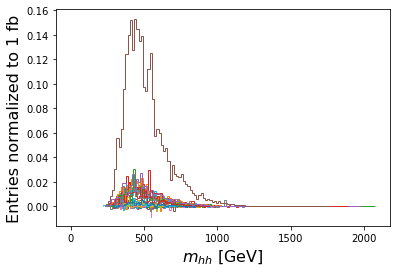

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log


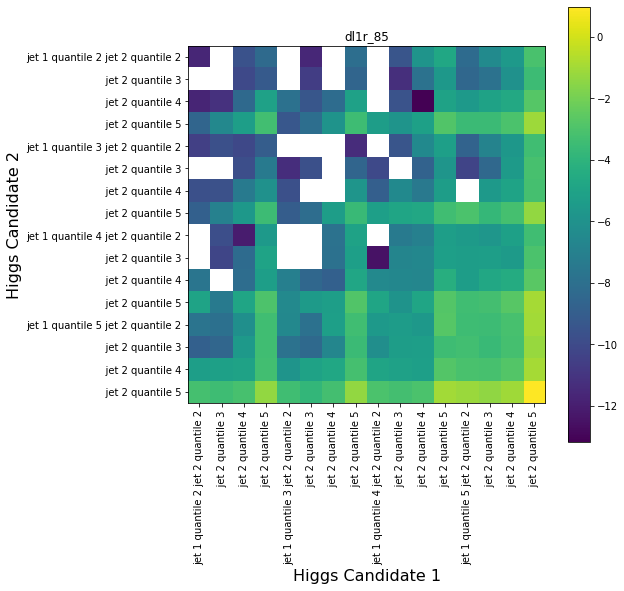

In [23]:
sig = np.zeros((16,16))

plt.figure()

for q11,q12,q21,q22 in itertools.product(*[range(2,6)]*4):
    
    mask = (df.quantile_h1_j1==q11) & (df.quantile_h1_j2==q12) & (df.quantile_h2_j1==q21) & (df.quantile_h2_j2==q22)
    mask = mask & (df.ntag>=4)
            
    n,_,_ = plt.hist(df.loc[mask,'m_hh'],100,histtype='step',weights=df.loc[mask,'mc_sf'])

    i = (q11-2)*4+(q12-2)
    j = (q21-2)*4+(q22-2)
    
    sig[i,j] = np.sum(n)


plt.xlabel('$m_{hh}$ [GeV]',fontsize=16)
plt.ylabel('Entries normalized to 1 fb',fontsize=16)
plt.show()


plt.figure(figsize=(8,8))

plt.imshow(np.log(sig.T))

ax = plt.gca()

labels = [f'jet 1 quantile {q1} jet 2 quantile {q2}' if q2==2 \
          else f'                    jet 2 quantile {q2}' \
          for q1,q2 in itertools.product(range(2,6),range(2,6))]

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels,rotation="vertical")

ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)

plt.xlabel('Higgs Candidate 1',fontsize=16)
plt.ylabel('Higgs Candidate 2',fontsize=16)

plt.title(key)
plt.colorbar()

plt.show()

Ok, at this point $16^2 = 256$ options - this would be a lot of categories!

Rafael wanted me to try to aggregate how much I was actually gaining by these categories, so I'm going to make $m_{hh}$ histograms for how much we gain (in signal efficiency) each time we loosen the WP. 

**60% WP**

For this category, I only have one possibility: they're all in ...

It might be useful to try to quantify


In [24]:
bdt.keys()

dict_keys(['mv2c10_60', 'mv2c10_70', 'mv2c10_77', 'mv2c10_85', 'dl1r_60', 'dl1r_70', 'dl1r_77', 'dl1r_85'])

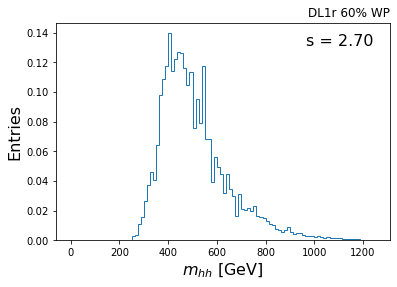

In [25]:
plt.hist(bdt['dl1r_60'].loc[bdt['dl1r_60'].ntag>=4,'m_hh'],100,(0,1250),
         histtype='step',
         weights=bdt['dl1r_60'].loc[bdt['dl1r_60'].ntag>=4,'mc_sf'])
plt.xlabel('$m_{hh}$ [GeV]',fontsize=16)
plt.ylabel('Entries',fontsize=16)
plt.title('DL1r 60% WP',loc='right')

ax = plt.gca()
s = np.sum(bdt['dl1r_60'].loc[bdt['dl1r_60'].ntag>=4,'mc_sf'])
plt.text(.95,.95,f"s = {s:0.2f}",fontsize=16,
         ha='right',va='top',transform=ax.transAxes)

plt.show()

**70% WP**

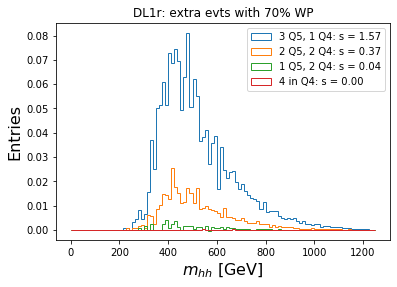

In [26]:
masks = [
    (bdt['dl1r_70'].nQ5==3)&(bdt['dl1r_70'].nQ4==1),
    (bdt['dl1r_70'].nQ5==2)&(bdt['dl1r_70'].nQ4==2),
    (bdt['dl1r_70'].nQ5==1)&(bdt['dl1r_70'].nQ4==3),
    (bdt['dl1r_70'].nQ4==4),
]

ls = [
    '3 Q5, 1 Q4',
    '2 Q5, 2 Q4',
    '1 Q5, 3 Q4',
    '4 in Q4'
]

for mask,l in zip(masks,ls):

    s = np.sum(bdt['dl1r_70'].loc[mask,'mc_sf'])
    plt.hist(bdt['dl1r_70'].loc[mask,'m_hh'],100,(0,1250),
             histtype='step',label=f"{l}: s = {s:.2f}",
             weights=bdt['dl1r_70'].loc[mask,'mc_sf'])
    
    #print(l,f"{l}: s=",)
    
plt.xlabel('$m_{hh}$ [GeV]',fontsize=16)
plt.ylabel('Entries',fontsize=16)
plt.title('DL1r: extra evts with 70% WP')
plt.legend()

plt.show()

Rafael *also* wants me to overlay this plot with the 4 Q5 histogram!

(Idk what this will tell us tho.)

**77% WP**

Ok, now enumerating over all the possible options will get a bit more harry, but I should still be able to do it!


I now have **10 options**, so I think I might color code by # of jets in quantile 3, and then use linestyles to denote the purity.

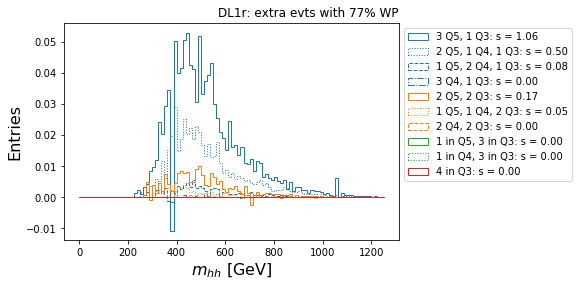

In [27]:
masks = [
    # 1 jet in Q3
    (bdt['dl1r_77'].nQ5==3)&(bdt['dl1r_77'].nQ3==1),
    (bdt['dl1r_77'].nQ5==2)&(bdt['dl1r_77'].nQ4==1)&(bdt['dl1r_77'].nQ3==1),
    (bdt['dl1r_77'].nQ5==1)&(bdt['dl1r_77'].nQ4==2)&(bdt['dl1r_77'].nQ3==1),
    (bdt['dl1r_77'].nQ4==3)&(bdt['dl1r_77'].nQ3==1),
    
    # 2 jets in Q3
    (bdt['dl1r_77'].nQ5==2)&(bdt['dl1r_77'].nQ3==2),
    (bdt['dl1r_77'].nQ5==1)&(bdt['dl1r_77'].nQ4==1)&(bdt['dl1r_77'].nQ3==2),
    (bdt['dl1r_77'].nQ4==2)&(bdt['dl1r_77'].nQ3==2),
    
    # 3 jets in Q3
    (bdt['dl1r_77'].nQ5==1)&(bdt['dl1r_77'].nQ3==3),
    (bdt['dl1r_77'].nQ4==1)&(bdt['dl1r_77'].nQ3==3),
    
    # All jets in Q3
    (bdt['dl1r_77'].nQ3==4),
]

labels77 = [
    '3 Q5, 1 Q3',
    '2 Q5, 1 Q4, 1 Q3',
    '1 Q5, 2 Q4, 1 Q3',
    '3 Q4, 1 Q3',
    
    '2 Q5, 2 Q3',
    '1 Q5, 1 Q4, 2 Q3',
    '2 Q4, 2 Q3',
    
    '1 in Q5, 3 in Q3',
    '1 in Q4, 3 in Q3',
    
    '4 in Q3'

]


# labels77 = [
#     '3 60%, 1 777%',
#     '2 60%, 1 70%, 1 77%',
#     '1 60%, 2 70%, 1 77%',
#     '3 60%, 1 77%',
    
#     '2 60%, 2 77%',
#     '1 60%, 1 70%, 2 77%',
#     '2 70%, 2 77%',
    
#     '1 in 60%, 3 in 77%',
#     '1 in 70%, 3 in 77%',
    
#     '4 in 77%'
# ]


colors = ['C0']*4+['C1']*3+['C2']*2+['C3']
styles = ['-','dotted','--','-.',
          '-','dotted','--',
          '-','dotted',
          '-']


for mask,l,c,ls in zip(masks,labels77,colors,styles):

    s = np.sum(bdt['dl1r_77'].loc[mask,'mc_sf'])
    plt.hist(bdt['dl1r_77'].loc[mask,'m_hh'],100,(0,1250),
             histtype='step',label=f"{l}: s = {s:.2f}",
             color=c,linestyle=ls,
             weights=bdt['dl1r_77'].loc[mask,'mc_sf'])
    
    
plt.xlabel('$m_{hh}$ [GeV]',fontsize=16)
plt.ylabel('Entries',fontsize=16)
plt.title('DL1r: extra evts with 77% WP',loc='right')
plt.legend(bbox_to_anchor=(1,1))

plt.show()


Ok so what we would gain by the 70% WP is basically the orange 2Q5, 2 Q3 category, and a little bit from the 1 Q5, 1 Q4 category.

**85% WP**

There are a lot more options here, so I'm going to break it into cases where only one of the jets is in quantile 2 versus two or more jets being in quantile 2.

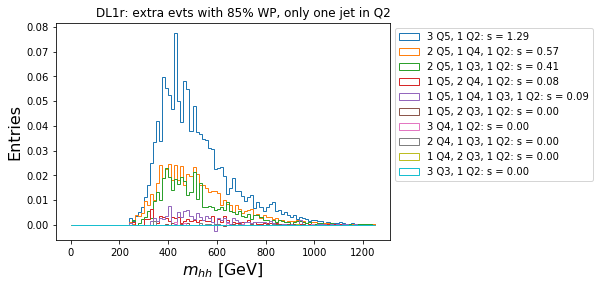

In [28]:
# Only one jet in Q2

masks = [
    (bdt['dl1r_85'].nQ5==3),
    (bdt['dl1r_85'].nQ5==2) & (bdt['dl1r_85'].nQ4==1),
    (bdt['dl1r_85'].nQ5==2) & (bdt['dl1r_85'].nQ3==1),
    (bdt['dl1r_85'].nQ5==1) & (bdt['dl1r_85'].nQ4==2),
    (bdt['dl1r_85'].nQ5==1) & (bdt['dl1r_85'].nQ4==1) & (bdt['dl1r_85'].nQ3==1) ,
    (bdt['dl1r_85'].nQ5==1) & (bdt['dl1r_85'].nQ3==2) ,
    (bdt['dl1r_85'].nQ4==3),
    (bdt['dl1r_85'].nQ4==2) & (bdt['dl1r_85'].nQ3==1) ,
    (bdt['dl1r_85'].nQ4==1) & (bdt['dl1r_85'].nQ3==2) ,
    (bdt['dl1r_85'].nQ3==3)
]

masks = [m & (bdt['dl1r_85'].nQ2==1) for m in masks]

labels85 = [
    '3 Q5, 1 Q2',
    
    '2 Q5, 1 Q4, 1 Q2',
    '2 Q5, 1 Q3, 1 Q2',
    
    '1 Q5, 2 Q4, 1 Q2',
    '1 Q5, 1 Q4, 1 Q3, 1 Q2',
    '1 Q5, 2 Q3, 1 Q2',
    
    '3 Q4, 1 Q2',
    '2 Q4, 1 Q3, 1 Q2',
    '1 Q4, 2 Q3, 1 Q2',
    '3 Q3, 1 Q2'
]


for mask,l in zip(masks,labels85):

    s = np.sum(bdt['dl1r_85'].loc[mask,'mc_sf'])
    plt.hist(bdt['dl1r_85'].loc[mask,'m_hh'],100,(0,1250),
             histtype='step',label=f"{l}: s = {s:.2f}",
             #color=c,linestyle=ls,
             weights=bdt['dl1r_85'].loc[mask,'mc_sf'])
    
    
plt.xlabel('$m_{hh}$ [GeV]',fontsize=16)
plt.ylabel('Entries',fontsize=16)
plt.title('DL1r: extra evts with 85% WP, only one jet in Q2',loc='right')
plt.legend(bbox_to_anchor=(1,1))

plt.show()



Ok, nice! It's interesting to me that we're seeing roughly the same gains with this 3b category as we were seeing with the other two categories combined.

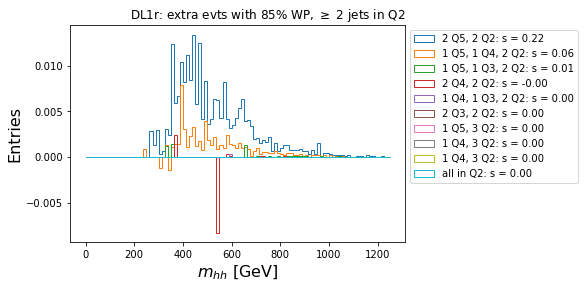

In [29]:
masks = [
    
    # 2 jets in Q2
    (bdt['dl1r_85'].nQ5==2) & (bdt['dl1r_85'].nQ2==2),
    (bdt['dl1r_85'].nQ5==1) & (bdt['dl1r_85'].nQ4==1) & (bdt['dl1r_85'].nQ2==2),
    (bdt['dl1r_85'].nQ5==1) & (bdt['dl1r_85'].nQ3==1) & (bdt['dl1r_85'].nQ2==2),
    (bdt['dl1r_85'].nQ4==2) & (bdt['dl1r_85'].nQ2==2),
    (bdt['dl1r_85'].nQ4==1) & (bdt['dl1r_85'].nQ3==1) & (bdt['dl1r_85'].nQ2==2),
    (bdt['dl1r_85'].nQ3==2) & (bdt['dl1r_85'].nQ2==2),
    
    # 3 jets in Q2
    (bdt['dl1r_85'].nQ5==1)&(bdt['dl1r_77'].nQ2==3),
    (bdt['dl1r_85'].nQ4==1)&(bdt['dl1r_77'].nQ2==3),
    (bdt['dl1r_85'].nQ3==1)&(bdt['dl1r_77'].nQ2==3),
    
    # all jets in Q2
    (bdt['dl1r_85'].nQ2==4),
]

labels85 = [
    '2 Q5, 2 Q2',
    '1 Q5, 1 Q4, 2 Q2',
    '1 Q5, 1 Q3, 2 Q2',
    '2 Q4, 2 Q2',
    '1 Q4, 1 Q3, 2 Q2',
    '2 Q3, 2 Q2',
    '1 Q5, 3 Q2',
    '1 Q4, 3 Q2',
    '1 Q4, 3 Q2',
    'all in Q2'
]

for mask,l in zip(masks,labels85):

    s = np.sum(bdt['dl1r_85'].loc[mask,'mc_sf'])
    plt.hist(bdt['dl1r_85'].loc[mask,'m_hh'],100,(0,1250),
             histtype='step',label=f"{l}: s = {s:.2f}",
             #color=c,linestyle=ls,
             weights=bdt['dl1r_85'].loc[mask,'mc_sf'])
    
plt.xlabel('$m_{hh}$ [GeV]',fontsize=16)
plt.ylabel('Entries',fontsize=16)
plt.title('DL1r: extra evts with 85% WP, $\geq$ 2 jets in Q2',loc='right')
plt.legend(bbox_to_anchor=(1,1))

plt.show()



Only the blue will contribute at all to the limit - and I'm not even sure if it will.

I think a useful way to categorize this might be to make a bar plot, but now w/ these new and improved categories: there will now only be 35 options, instead of 256.

This way, I can overlay signal and background pretty easily!

## Step 2: Compare signal yields

**Main question** If Beojean trained on MV2c10 jets, will the BDT still be optimal for the DL1r algorithm?


In [30]:
mdr['mv2c10_70'].head()

run_number  event_number     mc_sf  ntag  njets  kinematic_region  \
entry                                                                      
0          301973        624722  0.000097     3      5                 0   
1          310249        624160  0.000146     3      4                 0   
2          311287        958883  0.000116     3      4                 0   
3          307601        624468  0.000309     3      4                 0   
4          303638        624442  0.000327     2      4                 0   

         m_min_dj    m_max_dj  pairing_score_1  pairing_score_2  ...  \
entry                                                            ...   
0      112.888306  557.624207              0.0              0.0  ...   
1      108.126678  468.078766              0.0              0.0  ...   
2      125.237946  524.043030              0.0              0.0  ...   
3      103.954979  379.628754              0.0              0.0  ...   
4       99.073250  479.535248              0.0              0.0  ...   

            pT_4        pT_2     eta_i    dRjj_1    dRjj_2  nQ1  nQ2  nQ3  \
entry                                                                       
0      83.556099  238.397552  0.405462  0.593325  0.731039    1    0    0   
1      64.240341  216.916901  0.375669  0.737864  0.793690    1    0    0   
2      70.873749  216.139694  0.456333  0.801049  0.820885    0    0    1   
3      63.118134  160.798767  1.203772  0.828646  0.923503    0    1    0   
4      51.263622  210.105606  0.438043  0.607021  0.825938    2    0    0   

       nQ4  nQ5  
entry            
0        0    3  
1        1    2  
2        2    1  
3        0    3  
4        0    2  

[5 rows x 65 columns]

## Step 3: Get a background estimate

Sean ran this for us today, so I've downloaded his filess so I should just be able to load them in!

In [31]:
fDir

'../../hh4b/hh4b-resolved-reconstruction'

In [32]:
SeanDir = "../../public/hh4b/bTagOptStudies/SeansFiles"

data_SR = {}

for tagger in ['mv2c10','dl1r']:
    for wp in [60,70,77,85]:

        col = f"{tagger}_{wp}"
        print(col)
        rr = uproot.open(f"{SeanDir}/{tagger}/{wp}/data16_with_weights.root")
        
        df = rr["fullmassplane"].pandas.df()
        df['NN_d24_weight_16'] *= rr['NN_norm_16']._fVal
        df['NN_d24_weight_CRderiv_16'] *= rr['NN_norm_CRderiv_16']._fVal
        
        # For the background estimate, load in the 2b data
        data_SR[col] = df[(df.kinematic_region==0)&(df.ntag==2)]
        

mv2c10_60
mv2c10_70
mv2c10_77
mv2c10_85
dl1r_60
dl1r_70
dl1r_77
dl1r_85


In [33]:
for tagger in ['mv2c10','dl1r']:
    for wp in [60,70,77,85]:

        col = f"{tagger}_{wp}"
        
        rr = uproot.open(f"{SeanDir}/{tagger}/{wp}/data16_with_weights.root")
        print(col,rr['NN_norm_16']._fVal,rr['NN_norm_CRderiv_16']._fVal)
        

mv2c10_60 0.9218206696990242 1.126364594373195
mv2c10_70 0.9898709823140042 0.8562700868556258
mv2c10_77 1.077474091106829 1.0173369982865879
mv2c10_85 0.9590995747522316 1.078691154772225
dl1r_60 0.8558659843215899 1.3431241334541568
dl1r_70 1.0130090090529689 0.8299027581687041
dl1r_77 0.9726354360722875 1.0470701822828263
dl1r_85 1.0144711213413018 1.0873196836089165


In [34]:
rr[b'NN_norm_16;1'].__dict__

{'_fName': b'NN_norm', '_fVal': 1.0144711213413018}

Ok, so Beojean doesn't write out the signal dataframe for the data when we're running in the blinded mode.

In [35]:
for k in rr.keys():
    print(k)

b'TwoTagCutflow;1'
b'FourTagCutflow;1'
b'isMC;1'
b'NN_norm_16;1'
b'fullmassplane;1'
b'control;1'
b'sideband;1'
b'leptop_muon;1'
b'leptop_hadron;1'
b'hadtop;1'
b'top_multijet;1'
b'NN_norm_CRderiv_16;1'


## Step 4: Look at all the standard kinematic plots

## Step 5:  Get the SM limit

### First get the stats only limit

In [36]:
edges = np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 402, 422, 443, 465, 488, 512, 
                  537, 563, 591, 620, 651, 683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 1161, 
                  1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884, 1978, 2076])
x = 0.5*(edges[:-1]+edges[1:])

In [37]:
text = '$\mathbf{ATLAS}$ Internal\n'
text += r'$hh \rightarrow 4b$ resolved analysis'

In [38]:
cols = [f"{tagger}_{wp}" for tagger in ['mv2c10','dl1r'] for wp in [60,70,77,85]]

yields = pd.DataFrame(0,index=['$s$','$b$','$s/\sqrt{b}$', '$s/b$'],columns=cols)

In [39]:
# The stats results
bidx = ['$-2\sigma$','$-\sigma$','exp','$+\sigma$', '$+2\sigma$']
mu_tests = np.linspace(1,50, 50)

stats = pd.DataFrame(0,index=bidx,columns=cols)
sys   = pd.DataFrame(0,index=bidx,columns=cols)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in multiply
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


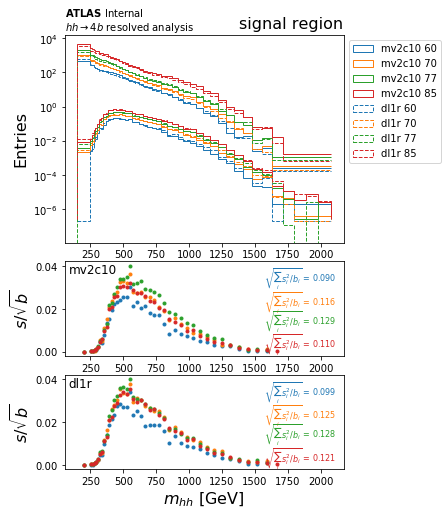

In [40]:
fig = plt.figure(figsize=(5, 8))
gs = gridspec.GridSpec(4,1)
ax = fig.add_subplot(gs[:2,0])
ax1 = fig.add_subplot(gs[2:3,0],sharex=ax)
ax2 = fig.add_subplot(gs[3:,0],sharex=ax)

# Loop through the options (using the bdt pairing)
for tagger, ls, axi in zip(['mv2c10','dl1r'],['-','--'],[ax1,ax2]):
    for wp, color, ytxt in zip([60,70,77,85],['C0','C1','C2','C3'],[.95,.7,.5,.25]):
        
        c = f"{tagger}_{wp}"
        
        # signal
        SR = bdt[c]
        s,_,_ = ax.hist(bdt[c].loc[bdt[c].ntag>=4,'m_hh'],
                        edges,color=color,histtype='step',log=True,
                        label=f"{tagger} {wp}",ls=ls,
                        weights=bdt[c].loc[bdt[c].ntag>=4,'mc_sf'])
        
        # background
        b,_,_ = ax.hist(data_SR[c]['m_hh'],
                        edges,color=color,histtype='step',log=True,
                        ls=ls,weights=data_SR[c]['NN_d24_weight_16'])
        
        # Save the yields
        yields.loc['$s$',c] = np.sum(s)
        yields.loc['$b$',c] = np.sum(b)
        yields.loc['$s/\sqrt{b}$',c] = np.sum(s) / np.sqrt(np.sum(b))
        yields.loc['$s/b$',c] = np.sum(s) / np.sum(b)
        
        '''
        It would be great to just run the limit here
        '''
        band = getExpectedBand(s,b,mu_tests)
        stats.loc[bidx,c] = band
        
        # Significance (it probably would be a good idea to put mv2 and dl1r in different subpanels)
        axi.plot(x,s/np.sqrt(b),marker='.',color=color,linewidth=0)
        
        # Calculate the limit
        sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '

        axi.text(.975,ytxt,sigText+'{:.3f}'.format(np.sqrt(np.sum(s[b!=0]**2 / b[b!=0]))),
                 fontsize=8,ha='right',va='top',
                 transform=axi.transAxes,color=color)
     
    # Text per subfig
    axi.text(0.015,.975,tagger,fontsize=12,ha='left',va='top',
             transform=axi.transAxes)
    axi.set_ylabel('$s / \sqrt{b}$',fontsize=16)
    
    
# Make the plot pretty
ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=16)
ax.set_ylabel('Entries', fontsize=16)
ax.set_title('signal region', loc='right',fontsize=16)
ax.legend(bbox_to_anchor=(1,1))

ax.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig('figures/m_hh_SR_mv2_dl1r_allWPs.pdf',bbox_inches='tight')

plt.show()

Rafael also wants me to make this plot with only mv2 70%, dl1 70 and 77% WPs.

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


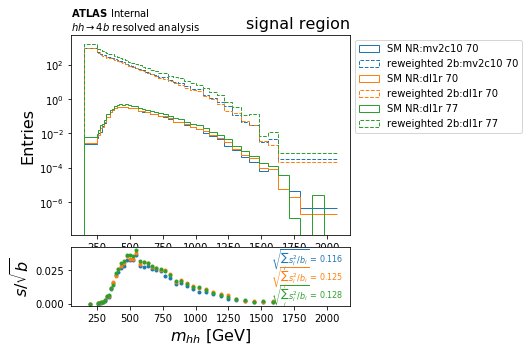

In [63]:
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

# Loop through the options (using the bdt pairing)
for c,color,ytxt in zip(['mv2c10_70','dl1r_70','dl1r_77'],['C0','C1','C2'],[1,.7,.4]):

    # signal
    s,_,_ = ax1.hist(bdt[c].loc[bdt[c].ntag>=4,'m_hh'],
                     edges,color=color,histtype='step',log=True,
                     label="SM NR:"+c.replace("_"," "),ls='-',
                     weights=bdt[c].loc[bdt[c].ntag>=4,'mc_sf'])

    # background
    b,_,_ = ax1.hist(data_SR[c]['m_hh'],
                     edges,color=color,histtype='step',log=True,
                     label="reweighted 2b:"+c.replace("_"," "),ls='--',
                     weights=data_SR[c]['NN_d24_weight_16'])

    # Significance (it probably would be a good idea to put mv2 and dl1r in different subpanels)
    ax2.plot(x,s/np.sqrt(b),marker='.',color=color,linewidth=0)

    # Calculate the limit
    sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '

    ax2.text(.975,ytxt,sigText+'{:.3f}'.format(np.sqrt(np.sum(s[b!=0]**2 / b[b!=0]))),
             ha='right',va='top',fontsize=8,
             transform=ax2.transAxes,color=color)

# Text per subfig
ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

    
# Make the plot pretty
ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=16)
ax1.set_ylabel('Entries', fontsize=16)
ax1.set_title('signal region', loc='right',fontsize=16)
ax1.legend(bbox_to_anchor=(1,1))

ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)

plt.savefig('figures/m_hh_SR_mv2_dl1r_mv2c10_70_dl1r_70_77.pdf',bbox_inches='tight')

plt.show()

In [ ]:
yields # in the SR

In [ ]:
stats # stats only limits

In [ ]:
stats[['mv2c10_70','dl1r_70','dl1r_77']]

In [ ]:
lumi

In [ ]:
df.columns

### Now get the systematics limit

**Plan:** I'm going to 

1. Loop over the taggers and WPs
2. Calculate the `HT` variable
3. Derive the $H_T$ variation histograms
4. Pass this (with the signal histogram) to the ``
5. Save the result to 

In [ ]:
mu_tests = np.linspace(1,150, 150)

In [ ]:
cols

In [ ]:
# Loop over the options
for c in cols:

    print(c)
    
    # Calculate HT
    data_SR[c]['HT'] = np.sum(data_SR[c][['pT_h1_j1','pT_h1_j2','pT_h2_j1','pT_h2_j2']],axis=1)
    df = data_SR[c]
    
    # Retrieve the signal histogram
    s,_ = np.histogram(bdt[c].loc[bdt[c].ntag>=4,'m_hh'],edges,
                       weights=bdt[c].loc[bdt[c].ntag>=4,'mc_sf'])
    
    var = {}
    
    for HT,tag,ylim in zip([(df.HT < 300),(df.HT >= 300)],
                           ['Low','High'],[(.94,1.06),(0.5,1.5)]):
        # Make the plot
        fig = plt.figure(figsize=(5, 5))
        gs = gridspec.GridSpec(4,1)
        ax1 = fig.add_subplot(gs[:3,0])
        ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

        b,_,_  = ax1.hist(df['m_hh'],edges,color='k',histtype='step',
                          label='Multijet',weights=df['NN_d24_weight_16'])

        vr,_,_ = ax1.hist(df['m_hh'],edges,color='b',histtype='step',
                          label=f'{tag} $H_T$ VR Weighted',
                          weights=np.where(HT,df['NN_d24_weight_CRderiv_16'],df['NN_d24_weight_16']))


        inv,_,_ = ax1.hist(df['m_hh'],edges,color='r',histtype='step',
                           label=f'{tag} $H_T$ VR Inverted',
                           weights=np.where(HT,2*df['NN_d24_weight_16']-df['NN_d24_weight_CRderiv_16'],
                                            df['NN_d24_weight_16']))

        ax2.plot(x,vr / b,marker='.',color='blue',linewidth=0)
        ax2.plot(x,inv/b,marker='.',color='r',linewidth=0)

        '''
        Append the histograms for the limits
        '''
        eps = 1e-15
        var[f'{tag}_HT'] = [list(vr+eps), list(inv+eps)]

        ax2.set_xlabel('$m_{hh}$',fontsize=16)

        ax1.set_ylabel('Entries',fontsize=16)
        ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)

        ax1.text(0.85,.55,c.replace("_"," ")+"% WP",fontsize=16,
                 ha='right',va='top',transform=ax1.transAxes)
            
        ax2.set_ylabel('Var / Nom',fontsize=12)

        ax1.legend(fontsize=12)#,bbox_to_anchor=(1,1.05))
        ax1.set_title('signal region', loc='right',fontsize=14)

        ax2.set_ylim(ylim)

        # Save the plot
        plt.savefig(f'figures/{c}/m_hh_SR_{tag}_HT.pdf',bbox_inches='tight')

        plt.show()
    
    # Get the limit with the background systematic
    band = getBkgSysBand(s,b,var,mu_tests)
    
    # Save the limit with the background systematic
    sys.loc[bidx,c] = band
    

In [ ]:
mu_tests

In [ ]:
sys

In [ ]:
sys[['mv2c10_70','dl1r_70','dl1r_77']]

## Step 6: Using the b-tagging quantile info

Ok, so there will obviously be some trade off between the operating point and the final limit, but I think the take away from this HHarmonization meeting should be that we want as loose of a WP as possible.

I'm not sure if this will be demonstratable from a standard limit from the baseline analysis, but if I use quantile information, I should be able to make new analysis categories that demonstrate how much signficance we gain by using different PC bins for the limit.

**Compare yields**

**Compare yields with the quantile information**

## Step 7: Get the $\kappa_\lambda$ variation histograms and the limit

**Next:** I want to look at the $\kappa_\lambda$ variation histograms just for mv2c10 70% WP and dl1r 70% and 77% WPs.

**Step 1:** Get the variation histograms

In [ ]:
subsetCols = ['mv2c10_70','dl1r_70','dl1r_77']

index = pd.MultiIndex.from_tuples(itertools.product(subsetCols,bidx))
lambdas = np.arange(-20,21)

lims = pd.DataFrame(0,index,lambdas)

mu_max = 100
mu_tests_lmbda = np.concatenate((np.linspace(.01,.95,25),np.linspace(1,mu_max,4*mu_max)))
mH=125

In [ ]:
for c in ['mv2c10_70','dl1r_70','dl1r_77']:
    
    print(c)
    
    # Calculate m_hh_cor for the signal histograms
    hc1 = TLorentzVectorArray.from_ptetaphim(bdt[c].pT_h1,bdt[c].eta_h1,bdt[c].phi_h1,bdt[c].m_h1)
    hc2 = TLorentzVectorArray.from_ptetaphim(bdt[c].pT_h2,bdt[c].eta_h2,bdt[c].phi_h2,bdt[c].m_h2)
    
    cor_hc1 = mH * hc1._to_cartesian() / hc1.mag
    cor_hc2 = mH * hc2._to_cartesian() / hc2.mag
    
    bdt[c]['m_hh_cor'] = (cor_hc1 + cor_hc2).mag
    
    # Get the lambda variations
    getLambdaWeights(bdt[c])
    
    # Get the background histogram
    b,_  = np.histogram(data_SR[c]['m_hh'],edges,
                        weights=data_SR[c]['NN_d24_weight_16'])

    # Loop over the lambdas and  get the limit
    for l in tqdm(lambdas):

        si,_ = np.histogram(bdt[c].loc[bdt[c].ntag>=4,'m_hh'],edges, 
                            weights=bdt[c].loc[bdt[c].ntag>=4,'w_lambda{}'.format(l)])

        lims.loc[c,l] = np.array(getExpectedBand(hackHistogram(si), b, mu_tests_lmbda))
        

**Step 2:** Get the limits

**Step 3:** Make the limits pretty!

In [ ]:
normFactor = np.array([np.sum(bdt[c].loc[bdt[c].ntag>=4,'w_lambda{}'.format(l)]) for l in lambdas])
normFactor /= normFactor[21]
xsec = 31.05

# In pb, since this is what the ATLAS plot has
n = 0.001 * xsec * normFactor

In [ ]:
normFactor = np.array([np.sum(bdt['mv2c10_70'].loc[bdt['mv2c10_70'].ntag>=4,'w_lambda{}'.format(l)]) for l in lambdas])
normFactor /= normFactor[21]
xsec = 31.05

# In pb, since this is what the ATLAS plot has
n1 = 0.001 * xsec * normFactor

In [ ]:
normFactor = np.array([np.sum(bdt['dl1r_70'].loc[bdt['dl1r_70'].ntag>=4,'w_lambda{}'.format(l)]) for l in lambdas])
normFactor /= normFactor[21]
xsec = 31.05

# In pb, since this is what the ATLAS plot has
n2 = 0.001 * xsec * normFactor

In [ ]:
normFactor = np.array([np.sum(bdt['dl1r_77'].loc[bdt['dl1r_77'].ntag>=4,'w_lambda{}'.format(l)]) for l in lambdas])
normFactor /= normFactor[21]
xsec = 31.05

# In pb, since this is what the ATLAS plot has
n3 = 0.001 * xsec * normFactor

In [ ]:
plt.plot(n1)
plt.plot(n2)
plt.plot(n3)

In [ ]:
lambdas[21],normFactor[21]

In [ ]:
theory_line = pd.read_csv("../../hh4b/meta/theorycurvedigitized1.csv")

In [ ]:
plt.plot(theory_line.x,theory_line.y,color='k',linestyle='--',
             label='$\sigma_{ggF}$ from comb paper')

plt.plot(lambdas,n,'C4',label='my best try @ reproducing this')

plt.legend()
plt.xlabel('$\kappa_\lambda$')
plt.show()

In [ ]:
plt.plot(theory_line.x,theory_line.y,color='k',linestyle='--',
             label='$\sigma_{ggF}$ from comb paper')

plt.plot(lambdas,n,'C4',label='my best try @ reproducing this')

plt.xlim(-5,5)

plt.legend()
plt.xlabel('$\kappa_\lambda$')
plt.show()

And - there's good agreement close to the sm.

In [ ]:
o = np.ones_like(lambdas).astype('float')

for i,l in enumerate(lambdas):
    iloc = np.argmin(np.abs(theory_line.x-l).values)
    
    o[i] = theory_line.y.values[iloc]
    #print(iloc,theory_line.y.values[iloc],o[i])

In [ ]:
plt.plot(lambdas,n,'C4',marker='.',linewidth=0)
plt.plot(lambdas,o,'k',marker='.',linewidth=0)
plt.show()

In [ ]:
stdText = '$\mathbf{ATLAS}$ Internal 2016 data\n'
stdText += r'$\sigma_{ggF}(pp \rightarrow HH)$ = '
stdText += "{:.2f} fb\n".format(xsec)
stdText += r'$HH\rightarrow 4b$ resolved analysis'
stdText += '\nStats only limit'

In [ ]:
fig = plt.figure(figsize=(6, 6))

gs = gridspec.GridSpec(4,1)
ax = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax)

ax.semilogy(lambdas, n * lims.loc[('mv2c10_70','exp')],'k--',label='mv2c10_70')
ax.fill_between(lambdas, n * lims.loc[('mv2c10_70','$-2\sigma$')], n * lims.loc[('mv2c10_70','$+2\sigma$')],  facecolor = 'yellow')
ax.fill_between(lambdas, n * lims.loc[('mv2c10_70','$-\sigma$')], n * lims.loc[('mv2c10_70','$+\sigma$')],  facecolor = 'lime')

# The extra bands that I wanted to add
ax.semilogy(lambdas, n * lims.loc[('dl1r_70','exp')],color='b',linestyle='--',label='dl1r_70')
ax.semilogy(lambdas, n * lims.loc[('dl1r_77','exp')],color='g',linestyle='--',label='dl1r_77')

ax.plot(lambdas,n,'C4',label='theory prediction')

# ax.semilogy(lambdas, o * lims.loc[('mv2c10_70','exp')],'k--',label='mv2c10_70')
# ax.fill_between(lambdas, o * lims.loc[('mv2c10_70','$-2\sigma$')], o * lims.loc[('mv2c10_70','$+2\sigma$')],  facecolor = 'yellow')
# ax.fill_between(lambdas, o * lims.loc[('mv2c10_70','$-\sigma$')], o * lims.loc[('mv2c10_70','$+\sigma$')],  facecolor = 'lime')
# ax.semilogy(lambdas, o * lims.loc[('dl1r_70','exp')],color='b',linestyle='--',label='dl1r_70')
# ax.semilogy(lambdas, o * lims.loc[('dl1r_77','exp')],color='g',linestyle='--',label='dl1r_77')
# ax.plot(theory_line.x,theory_line.y,'C4',label='theory prediction')

ylim = [.01,200]
ax.plot([1]*2,ylim,'grey')
ax.set_ylim(ylim)

ax.set_ylabel('95% upper limit on $\sigma_{ggF}$ [pb]', fontsize=16)
ax.legend(loc='lower left')

ax2.plot(lambdas,lims.loc[('dl1r_70','exp')]/lims.loc[('mv2c10_70','exp')],
         color='b',linestyle='--')
ax2.plot(lambdas,lims.loc[('dl1r_77','exp')]/lims.loc[('mv2c10_70','exp')],
         color='g',linestyle='--')

ax2.plot(lambdas,np.ones_like(lambdas),'k--')

ax2.set_xlabel('$\kappa_\lambda$ = $\lambda_{HHH}$ / $\lambda_{SM}$', fontsize=16)
ax2.set_ylabel('1 / baseline')
ax2.set_ylim(0.5,1.5)

ax.text(0.025,.975,stdText,ha='left',va='top',transform=ax.transAxes)

plt.savefig('figures/kappa_lambda_scan_ratio.pdf',bbox_inches='tight')

plt.show()

**Sanity check:** Do I get the same result with this $\kappa_\lambda$ scan that I get from the stats only limits?

In [ ]:
lims[1]

In [ ]:
stats[subsetCols]

Ok, so I think that it should be ok to do this now...